In [ ]:
# Enhanced TensorFlow + Keras Image Classification Model
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt 
import pathlib
import os

# Constants
IMG_HEIGHT = 240
IMG_WIDTH = 240
BATCH_SIZE = 32
DATA_DIR = "../data/Set_A/Set_A/Train"

# Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.3),
    layers.RandomContrast(0.3),
    layers.RandomBrightness(0.3),
    layers.RandomTranslation(0.2, 0.2),
])

# Helper function to filter valid and non-corrupted image files
def filter_valid_images(directory):
    valid_extensions = {".jpg", ".jpeg", ".png", ".gif", ".bmp"}
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            if not any(file.lower().endswith(ext) for ext in valid_extensions):
                print(f"Removing unsupported file: {file_path}")
                os.remove(file_path)
            else:
                try:
                    # Attempt to open the image to check for corruption
                    img = tf.io.read_file(file_path)
                    tf.image.decode_image(img)
                except Exception as e:
                    print(f"Removing corrupted file: {file_path} due to error: {e}")
                    os.remove(file_path)

# Filter unsupported files in the dataset directory
filter_valid_images(DATA_DIR)

# Load Dataset
raw_train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
)
raw_val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
)

# Extract class names
class_names = raw_train_ds.class_names

# Apply Data Augmentation
train_ds = raw_train_ds.map(lambda x, y: (data_augmentation(x), y)).cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = raw_val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Compute Class Weights
y_train = []
for _, labels in raw_train_ds:  # Use raw_train_ds to get labels
    y_train.extend(labels.numpy())
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train,
)
class_weights = {i: weight for i, weight in enumerate(class_weights)}

# Build Model
base_model = MobileNetV2(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False, weights="imagenet")
base_model.trainable = False

model = models.Sequential([
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(len(class_names), activation="softmax"),
])

# Compile Model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

# Callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

# Train Model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    class_weight=class_weights,
    callbacks=[early_stopping],
)

# Save Model
model.save("flower_model_improved.keras")

Found 280 files belonging to 21 classes.
Using 224 files for training.
Using 224 files for training.
Found 280 files belonging to 21 classes.
Using 56 files for validation.
Found 280 files belonging to 21 classes.
Using 56 files for validation.


C:\Users\Admin\AppData\Local\Temp\ipykernel_172916\1989658998.py:87: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False, weights="imagenet")


Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 503ms/step - accuracy: 0.0538 - loss: 3.9521 - val_accuracy: 0.0536 - val_loss: 3.2447
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 503ms/step - accuracy: 0.0538 - loss: 3.9521 - val_accuracy: 0.0536 - val_loss: 3.2447
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 324ms/step - accuracy: 0.0787 - loss: 3.7680 - val_accuracy: 0.0536 - val_loss: 3.2246
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 324ms/step - accuracy: 0.0787 - loss: 3.7680 - val_accuracy: 0.0536 - val_loss: 3.2246
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 337ms/step - accuracy: 0.0919 - loss: 3.5401 - val_accuracy: 0.0536 - val_loss: 3.2005
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 337ms/step - accuracy: 0.0919 - loss: 3.5401 - val_accuracy: 0.0536 - val_loss: 3.2005
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 335ms/step - accuracy: 0.0713 - loss: 3.6657 - val_accuracy: 0.0357 - val_loss: 3.1773
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 335ms/step - accuracy: 0.0713 - loss: 3.6657 - val_accuracy: 0.0357 - val_loss:

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 797ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 797ms/step
0 Predict 17 - Hoa atiso with a 5.07 percent confidence. ::REAL 0_HoaSen.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
0 Predict 17 - Hoa atiso with a 5.07 percent confidence. ::REAL 0_HoaSen.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1 Predict 18 - Tung tuyet mai with a 5.11 percent confidence. ::REAL 10_Hoa dam but.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1 Predict 18 - Tung tuyet mai with a 5.11 percent confidence. ::REAL 10_Hoa dam but.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2 Predict 9 - Hoa sung with a 4.97 percent confidence. ::REAL 11_Hoa huong duong 002.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step2 Predict 9 - Hoa sung with a 4.97 percent confidence. ::REAL 11_Hoa huong duong 002.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
3 Predict 12 - Hong tu cau with a 5.91 percent confidence. ::REAL 12_Hong tu cau 005.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
3 Predict 12 - Hong tu

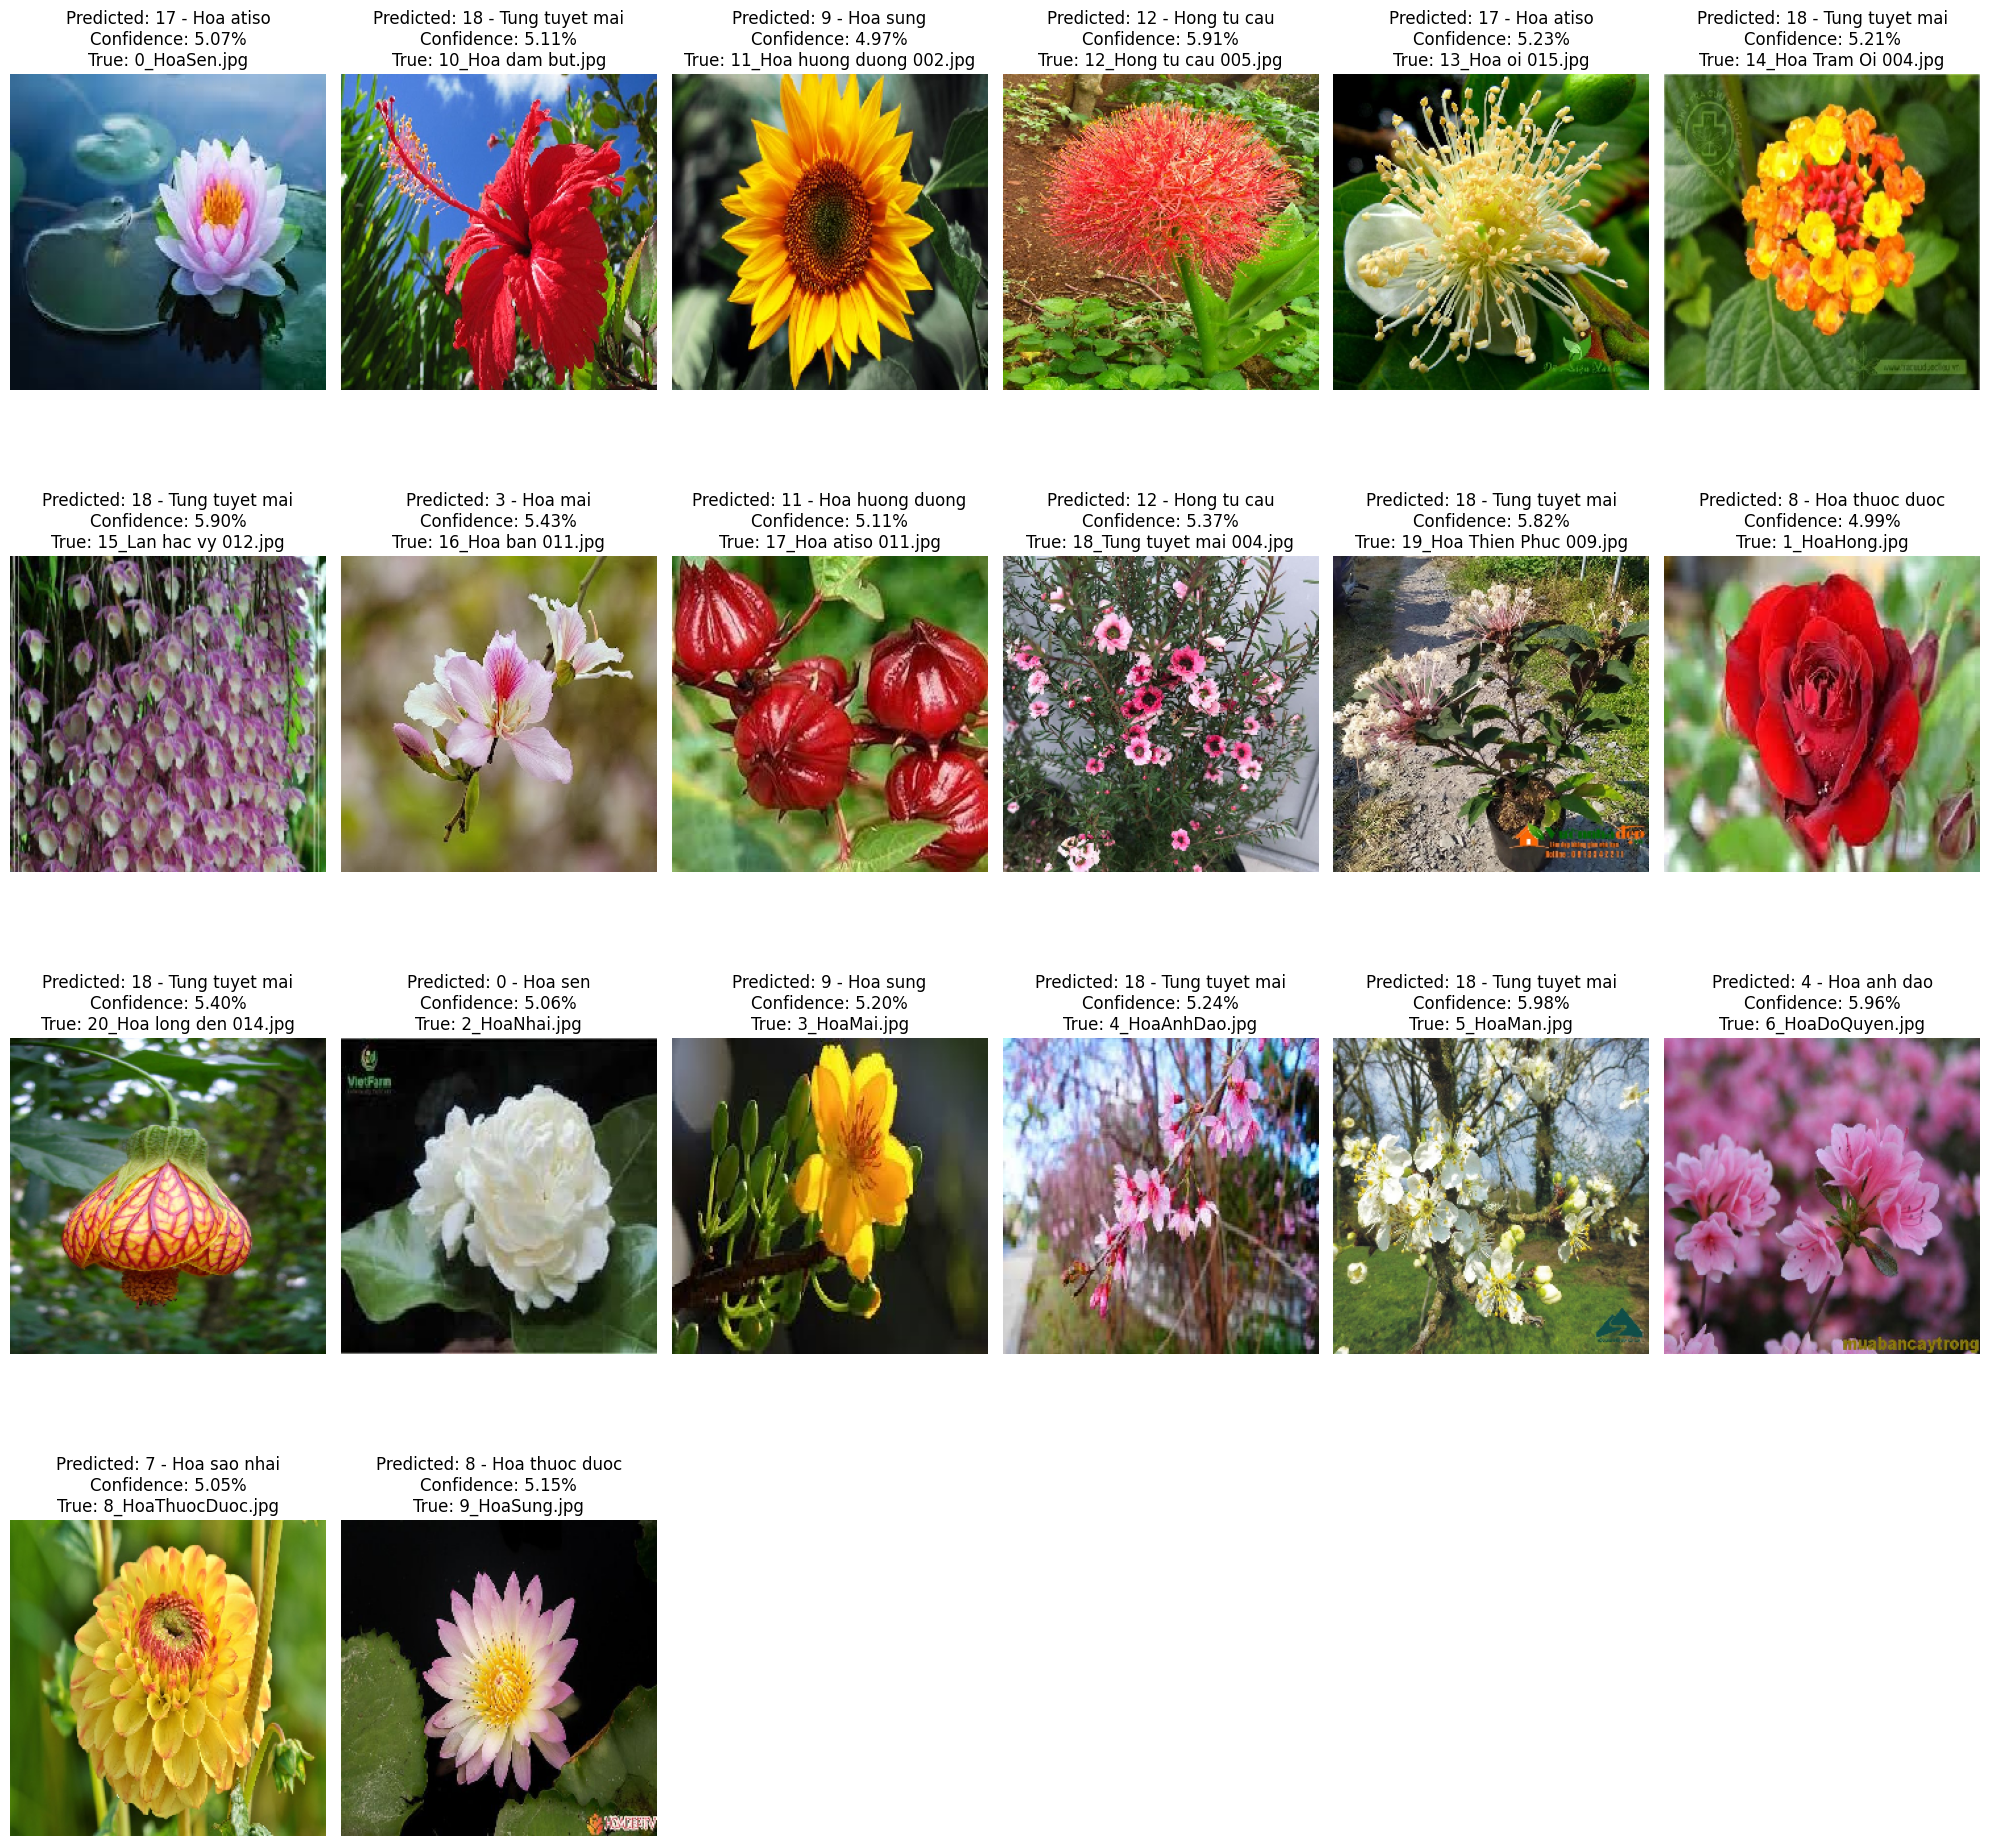

In [82]:
test_dir = pathlib.Path(r"D:\\BT\\2433_Emerging_Technologies\\data\\Set_A\\Set_A\\Test") 
listImages_test = list(test_dir.glob('*.jpg')) + list(test_dir.glob('*.webp')) + list(test_dir.glob('*.png')) + list(test_dir.glob('*.jpeg')) + list(test_dir.glob('*.jfif'))
plt.figure(figsize=(20, 20))
for i in range(len(listImages_test)):
    img = tf.keras.utils.load_img(
        listImages_test[i], target_size=(IMG_HEIGHT, IMG_HEIGHT)
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    predicted_name = class_names[np.argmax(score)]
    confidence = 100 * np.max(score)
    true_name = listImages_test[i].name  # Extract the true name from the file name
    print(i, f"Predict {predicted_name} with a {confidence:.2f} percent confidence. ::REAL {true_name}")
    plt.subplot((len(listImages_test)//6) + 1, 6, i + 1)
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_name}\nConfidence: {confidence:.2f}%\nTrue: {true_name}")
    plt.axis("off")

plt.tight_layout()
plt.show()